### Meanwhile in Germany:

You got pay rise of 500€!<br><br> Sounds pretty decent, right? Well, not so fast. The goal of this analysis is to plot how much money you will actually see in your account, depending on how much you earn already.

# Scroll down to data visualization if you're not interested in the code

### Data mining

In [26]:
base_url = "https://www.brutto-netto-rechner.info/"

In [141]:
import numpy
import pandas as pd
from selenium.webdriver.support.ui import Select
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import  BeautifulSoup
import time
import matplotlib.pyplot as plt

In [ ]:

base_url = "https://www.brutto-netto-rechner.info/"
driver = webdriver.Firefox()
driver.get(base_url)
time.sleep(3)
driver.find_element_by_xpath("//a[@class='eupopup-button eupopup-button_1 OKbutton']").click()
   
klasse = driver.find_element_by_id("f_steuerklasse")
klasse = Select(klasse)
klasse.select_by_visible_text("Klasse 1")

driver.find_elements_by_id("f_kirche")[1].click()

alter = driver.find_element_by_id("f_alter")
alter = Select(alter)
alter.select_by_visible_text("32")

bund = driver.find_element_by_id("f_bundesland")
bund = Select(bund)
bund.select_by_visible_text("Berlin")

results = []

for brutto in numpy.arange(20000, 101000, 1000):
    time.sleep(3)
    print(brutto)
    
    driver.find_element_by_id("f_bruttolohn").clear()
    driver.find_element_by_id("f_bruttolohn").send_keys(str(brutto / 12))
    driver.find_element_by_class_name("button").click()
    time.sleep(5)
    soup = BeautifulSoup(driver.page_source, "lxml")
    netto = soup.find("td", {'class' : "right_column orange big grey_bg"}).getText().strip()
    
    table_str = str(soup.find("table", {'class' : 'rechner'}))
    table = pd.read_html(table_str)[0]
    table.set_index(table[0], inplace=True)
    table = table[table.index.notnull()]
    table.index = [x.replace('\xa0', '') for x in table.index]

    netto_month = table.loc['Netto:'][2]
    krank = table.loc['Kranken-versicherung:'][2]
    pflege = table.loc['Pflege-versicherung:'][2]
    los = table.loc['Arbeitslosen-versicherung:'][2]
    lohnsteuer = table.loc['Lohnsteuer:'][2]
    rente = table.loc['Renten-versicherung:'][2]
    
    results.append( (brutto, netto_month, krank, pflege, los, lohnsteuer, rente))
    driver.find_element_by_class_name("button").click()
    
    

In [196]:
df = pd.DataFrame(results, columns=['brutto_year', 'netto_month', 'kranken', 'pflege', 'arblos', 'incometax', 'rente'])

In [197]:
df.to_pickle("brutto_netto.p")

In [198]:
#df = pd.read_pickle("brutto_netto.p")

In [201]:
df.columns[1:]

Index(['netto_month', 'kranken', 'pflege', 'arblos', 'incometax', 'rente'], dtype='object')

In [202]:
for col in df.columns[1:]:
    df[col] = df[col].str.replace("\.|\s|€", "").str.replace(",", ".").apply(float).round(0).apply(int)

In [204]:
df.head()

,brutto_year,netto_month,kranken,pflege,arblos,incometax,rente
0,20000,1227,129,30,20,102,155
1,21000,1273,136,31,21,120,163
2,22000,1321,142,33,22,138,170
3,23000,1369,149,34,23,155,178
4,24000,1417,155,36,24,173,186


In [205]:
df['brutto_month'] = df.brutto_year / 12
df['netto_year'] = df.netto_month * 12

In [207]:
df.head()


,brutto_year,netto_month,kranken,pflege,arblos,incometax,rente,brutto_month,netto_year
0,20000,1227,129,30,20,102,155,1666.666667,14724
1,21000,1273,136,31,21,120,163,1750.000000,15276
2,22000,1321,142,33,22,138,170,1833.333333,15852
3,23000,1369,149,34,23,155,178,1916.666667,16428
4,24000,1417,155,36,24,173,186,2000.000000,17004


Let's see how different tax/expenses rise, compared to how much you earn.

<Figure size 864x576 with 0 Axes>

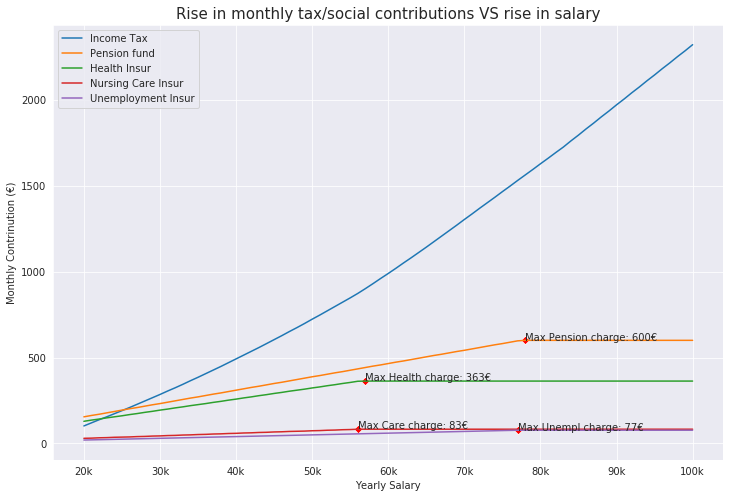

In [290]:
# rente, krank, pflege, arblos
max_brutto = [78000, 57000, 56000, 77000]
max_val = [600, 363, 83, 77]

sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)

sns.scatterplot(x=max_brutto, y=max_val, color='r', marker="D")

annot = ['Max Pension charge: 600€', 'Max Health charge: 363€', 'Max Care charge: 83€', 'Max Unempl charge: 77€']

for i, txt in enumerate(annot):
    ax.annotate(txt, (max_brutto[i], max_val[i]))
    
sns.lineplot(x=df.brutto_year, y=df.incometax)
sns.lineplot(x=df.brutto_year, y=df.rente)
sns.lineplot(x=df.brutto_year, y=df.kranken)
sns.lineplot(x=df.brutto_year, y=df.pflege)
sns.lineplot(x=df.brutto_year, y=df.arblos)

plt.legend(['Income Tax', 'Pension fund', 'Health Insur', 'Nursing Care Insur', 'Unemployment Insur', ])

#plt.xticks([str(int(x / 1000))+ "k" for x in numpy.arange(20000, 101000, 10000)])
plt.xlabel("Yearly Salary")
plt.ylabel("Monthly Contrinution (€)")

plt.title("Rise in monthly tax/social contributions VS rise in salary",  fontsize=15)

labels = ['{:,.0f}'.format(x) + 'k' for x in ax.get_xticks()/1000]
ax.set_xticklabels(labels);

### Main Takeaway:

The income tax continues to rise, but all other social contributions stop rising at certain points.

In [268]:
df['new_net_after_250_rise'] = df.netto_month.shift(-3)
df['net_gain'] = df.new_net_after_250_rise - df.netto_month
df['percent_net_gain'] = df.net_gain / 250
df.percent_net_gain = df.percent_net_gain.round(2) * 100

<Figure size 576x576 with 0 Axes>

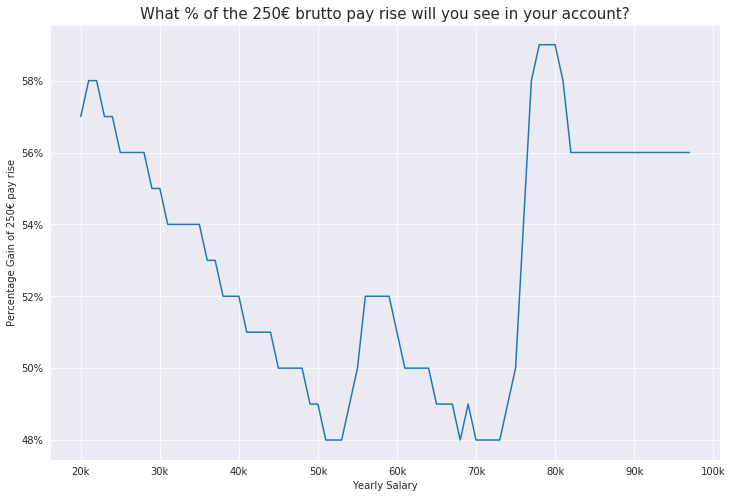

In [288]:
plt.figure(figsize=(8, 8))

fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.lineplot(df.brutto_year, df.percent_net_gain)

plt.xlabel("Yearly Salary")
plt.ylabel("Percentage Gain of 250€ pay rise")
plt.title("What % of the 250€ brutto pay rise will you see in your account?", fontsize=15)

labels_x = ['{:,.0f}'.format(x) + 'k' for x in ax.get_xticks()/1000]

labels_y = ['{:,.0f}'.format(x) + '%' for x in ax.get_yticks()]
ax.set_xticklabels(labels_x)

ax.set_yticklabels(labels_y);